# DC Cylindrical Target

[Lindsey Heagy](http://github.com/lheagy)

This notebook was used to produce Tables 1, 2 and Figures 14, 15, 16, 17, 18 in Heagy and Oldenburg, 2018. 

In [1]:
import os
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets
from string import ascii_lowercase
from matplotlib import rcParams, ticker
from matplotlib import patches

import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

import casingSimulations as casingSim

%matplotlib inline

In [17]:
include_target = True  # include models with the casing and target
include_offset = True  # include models with a gap between the casing and target
include_uncased = True  # include a suite of models without casing

In [18]:
rerun = False

In [105]:
simDir = 'DC_target'  # create a simulation directory where results can be saved. 

In [106]:
if rerun is False:  # download results
    f = simDir
    if not os.path.isdir(f):
        download = Utils.download(
            "https://storage.googleapis.com/simpeg/heagy_2018_dc_casing/{}.tar.gz".format(f)
        )  
        tar = tarfile.open(download, "r:*")
        tar.extractall()
        tar.close()

## Model  Parameters

In [20]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness
sigma_target = sigma_back
target_r = np.r_[0, 25.]
target_z = np.r_[-925., -900.]

model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    target_radius = target_r,
    target_z = target_z,
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[500., np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [21]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'CasingInHalfspaceWithTarget',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'DC_target',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'sigma_target': 0.01,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [500.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'target_radius': [0.0, 25.0],
 'target_theta': [0.0, 6.283185307179586],
 'target_z': [-925.0, -900.0],
 'version': '0.0.6'}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [37]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 8, 15  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(16)
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)
mesh = cylMeshGen.mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


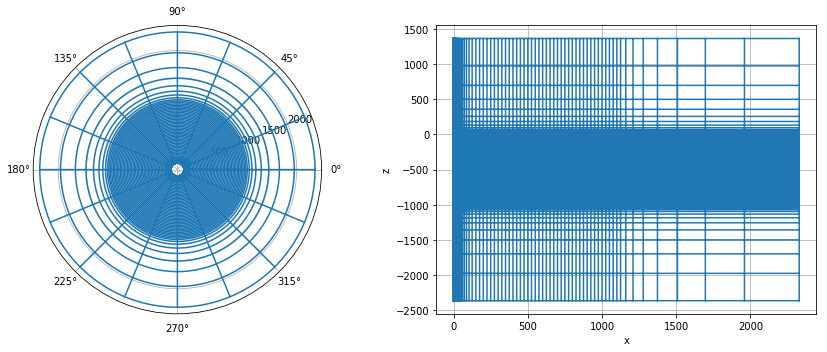

In [38]:
cylMeshGen.mesh.plotGrid()

In [39]:
src_theta = np.pi + hy[0]/2.

model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


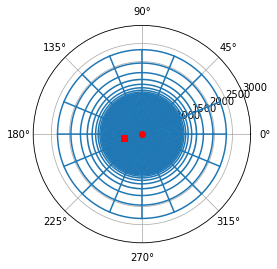

In [40]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [41]:
# put the models in a dictionary for convienence 

target_sigma = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

if include_target:
    model_names = ["target_{:1.0e}".format(sig) for sig in target_sigma]
else: 
    model_names = ["target_{:1.0e}".format(sig) for sig in [sigma_back]]
    

model_names_offset = ["offset_{:1.0e}".format(sig) for sig in target_sigma if sig != sigma_back]
# model_names_offset2 = ["offset2_{:1.0e}".format(sig) for sig in target_sigma if sig != sigma_back]
# model_names_offset3 = ["offset3_{:1.0e}".format(sig) for sig in target_sigma if sig != sigma_back]

if include_uncased:
    model_names_uncased = ["uncased_{:1.0e}".format(sig) for sig in target_sigma]

modelDict = {}

for name, sig in zip(model_names, target_sigma if include_target else [sigma_back]):
    tmp_model = model.copy()
    tmp_model.sigma_target = sig
    modelDict[name] = tmp_model

if include_offset: 
    for name, sig in zip(model_names_offset, [sig for sig in target_sigma if sig != sigma_back]):
        tmp_model = model.copy()
        tmp_model.sigma_target = sig
        tmp_model.target_radius = np.r_[tmp_model.casing_b + tmp_model.casing_t, 25.]
        modelDict[name] = tmp_model

    
#     for name, sig in zip(model_names_offset2, [sig for sig in target_sigma if sig != sigma_back]):
#         tmp_model = model.copy()
#         tmp_model.sigma_target = sig
#         tmp_model.target_radius = np.r_[tmp_model.casing_b + 1e-1, 25.]
#         modelDict[name] = tmp_model
    
#     for name, sig in zip(model_names_offset3, [sig for sig in target_sigma if sig != sigma_back]):
#         tmp_model = model.copy()
#         tmp_model.sigma_target = sig
#         tmp_model.target_radius = np.r_[tmp_model.casing_b + 1, 25.]
#         modelDict[name] = tmp_model


    model_names += model_names_offset 
#     model_names += model_names_offset2
#     model_names += model_names_offset3

if include_uncased:
    copiedmodelparams = {
        key: val for key, val in model.serialize().items() 
        if key in dir(casingSim.model.TargetInHalfspace) and not key.startswith('_') 
    }
    for name, sig in zip(model_names_uncased, target_sigma):
        tmp_model = casingSim.model.TargetInHalfspace(
            **copiedmodelparams
        )
        tmp_model.sigma_target = sig
        modelDict[name] = tmp_model
    model_names += model_names_uncased
    
modelDict

{'offset_1e+00': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd2ddfcd68>,
 'offset_1e+01': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd2ddfc8d0>,
 'offset_1e-02': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd23068e10>,
 'offset_1e-03': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd230684a8>,
 'target_1e+00': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd1af4a8d0>,
 'target_1e+01': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd2ddfce48>,
 'target_1e-01': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd2ddfc780>,
 'target_1e-02': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd2ddfca58>,
 'target_1e-03': <casingSimulations.model.CasingInHalfspaceWithTarget at 0xd2ddfc080>,
 'uncased_1e+00': <casingSimulations.model.TargetInHalfspace at 0xd2ddfca20>,
 'uncased_1e+01': <casingSimulations.model.TargetInHalfspace at 0xd2ddfc668>,
 'uncased_1e-01': <casingSimulations.model.TargetInHalfspace 

In [42]:
# Assign physical properties on the mesh
physpropsDict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, modelDict[key]) 
    for key in model_names
}

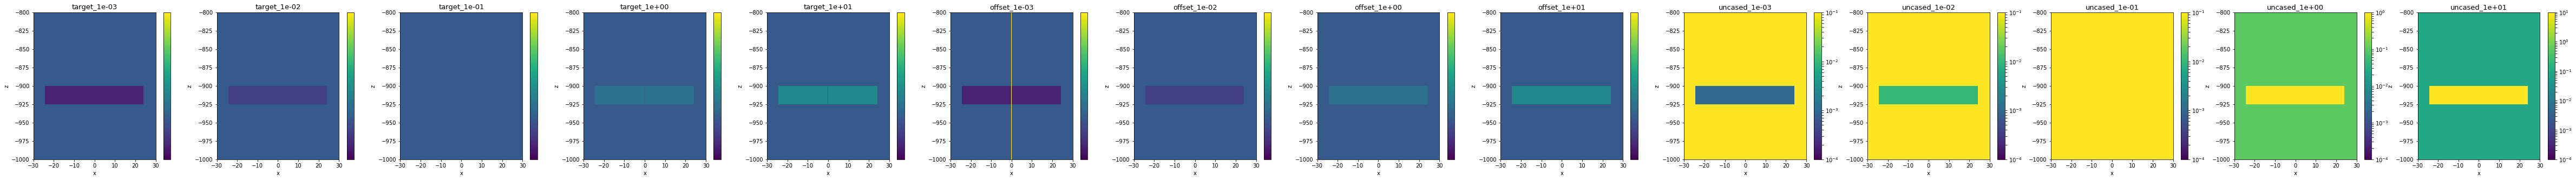

In [43]:
# Plot the models
xlim = 30*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1000, -800]

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax=[ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{}'.format(title), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Source locations

In [44]:
model.target_z

array([-925., -900.])

In [45]:
# Set up 2 sources, top casing & downhole

src_a = np.vstack([
    [model.casing_r, src_theta, -1.25],
    [model.casing_r, src_theta, model.target_z.mean()],
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
    "downhole",
]

## set up a DC simulation

In [46]:
simDict = {}
for title in model_names:
    if title not in simDict.keys():
        simDict[title] = casingSim.run.SimulationDC(
            modelParameters=modelDict[title], directory=simDir, 
            meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
        )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [47]:
# if rerun is False:
    # download result

In [56]:
sim = simDict[key]


array([1.00000000e-01, 1.00000000e-01, 1.00000000e-01, ...,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06])

In [60]:
%%time
fieldsDict = {}
for key in model_names:
    if key not in fieldsDict.keys():
        if rerun is True: 
            print('--- Running {} ---'.format(key))
            simDict[key].fields_filename = key + ".npy"
            soln = simDict[key].run()
            fieldsDict[key] = soln
            print('\n')
        else:
            print('Loading {} '.format(key))
            soln = np.load(os.path.sep.join([simDir, key + ".npy"]))
            simDict[key].prob.model = simDict[key].physprops.model
            fieldsDict[key] = simDict[key].prob.fieldsPair(mesh, simDict[key].survey)
            fieldsDict[key][:, simDict[key].prob._solutionType] = soln

--- Loading target_1e-03 ---


--- Loading target_1e-02 ---


--- Loading target_1e-01 ---


--- Loading target_1e+00 ---


--- Loading target_1e+01 ---


--- Loading offset_1e-03 ---


--- Loading offset_1e-02 ---


--- Loading offset_1e+00 ---


--- Loading offset_1e+01 ---


--- Loading uncased_1e-03 ---


--- Loading uncased_1e-02 ---


--- Loading uncased_1e-01 ---


--- Loading uncased_1e+00 ---


--- Loading uncased_1e+01 ---


CPU times: user 14.4 s, sys: 5.05 s, total: 19.5 s
Wall time: 14.4 s


## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [61]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, 
    primary_key=(
        "uncased_{:1.0e}".format(sigma_back) if include_uncased else 
        "target_{:1.0e}".format(sigma_back) 
    ),
    model_keys=model_names
)

In [62]:
viewer.widget_cross_section()

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('target_1e-03', 'target_1e-02', 'target_1e-01', 'target_1e+00', 'target_1e+01', 'offset_1e-03', 'offset_1e-02', 'offset_1e+00', 'offset_1e+01', 'uncased_1e-03', 'uncased_1e-02', 'uncased_1e-01', 'uncased_1e+00', 'uncased_1e+01', 'all'), value='target_1e-03'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=0, description='theta_ind', max=15), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [63]:
cylMeshGen.modelParameters = modelDict[model_names[0]]

In [64]:
rcParams['font.size'] = 14

### Plot the model, currents, charges and electric fields

- Figures 14, 15, 17

In [66]:
def plot_physics(plot_key="target"):
    assert plot_key in ["target", "uncased", "offset"]
    
    keys = ['{}_{:1.0e}'.format(plot_key, sig) for sig in [1e1, 1e-3]]
    fig, ax = plt.subplots(len(keys), 4, figsize=(4*3.5,len(keys)*5))

    fig.subplots_adjust(bottom=0.1)

    src_ind = 1
    theta_ind = 4

    max_r = 70
    min_depth = 825
    max_depth = 1025

    zlim = np.r_[-max_depth, -min_depth]
    xlim = max_r * np.r_[-1., 1.]
    stream_opts = {"color":"k", "arrowsize":1.5}

    for i, key in enumerate(keys):

        sigma_out = viewer.plot_cross_section(
            ax=ax[i][0], 
            clim=np.r_[1e-3, 1e7],
            xlim=xlim, 
            zlim=zlim,
            view='sigma', 
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            stream_opts=stream_opts,
            src_ind=src_ind
        )
        ax[i][0].text(
            max_r - 2, -max_depth+10, 
            "target: {:1.0e} S/m".format(float(key.split("_")[-1])), 
            color='w', fontsize=20, horizontalalignment="right"
        )

        currents_out = viewer.plot_cross_section(
            ax=ax[i][1], 
            clim= np.r_[1e-6, 1e-3],
            xlim=xlim, 
            zlim=zlim,
            view='j', 
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            cb_extend='bottom',
            stream_opts=stream_opts,
            src_ind=src_ind
        )

        charge_out = viewer.plot_cross_section(
            ax=ax[i][2], 
            clim= 2e-14 * np.r_[-1, 1] if key.startswith("uncased") else 2e-15 * np.r_[-1, 1],
            xlim=xlim, 
            zlim=zlim,
            view='charge_density', 
    #         prim_sec='secondary',
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            stream_opts=stream_opts,
            src_ind=src_ind
        )

        efields_out = viewer.plot_cross_section(
            ax=ax[i][3], 
            clim= np.r_[1e-5, 1e-1] if key.startswith("uncased") else np.r_[1e-5, 1e-2],
            xlim=xlim, 
            zlim=zlim,
            view='e', 
            theta_ind=theta_ind, 
            model_key=key, 
            show_cb=False, 
            use_aspect=True,
            casing_outline=False,
            cb_extend='bottom',
            stream_opts=stream_opts,
            src_ind=src_ind
        )

        if i == 0: 
            for j, a in enumerate(ax[i]):
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')
                a.set_ylabel('z (m)')
                a.set_title('({})'.format(ascii_lowercase[j]))
                if j > 0:
                    a.set_yticklabels(['']*len(a.get_xticklabels()))
                    a.set_ylabel('')
        else:
            for j, a in enumerate(ax[i]):
                a.set_xlabel('x (m)')
                a.set_title('')
                a.set_ylabel('z (m)')
                if j > 0:
                    a.set_yticklabels(['']*len(a.get_xticklabels()))
                    a.set_ylabel('')

    #     for a in ax[i]:
    #         plt.plot()


    # cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
    # cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')

    plt.tight_layout()

    for i, out, label in zip(
        np.arange(4), 
        [sigma_out, currents_out, charge_out, efields_out],
        ['conductivity (S/m)', 'current density (A/m$^2$)', 'charge \n density (C/m$^3$)', 'electric field (V/m)'],
    #     [None, None, 'min', 'min']
    ):
        x = ax[1][i].figbox.corners()[0, 0]
        cbar_ax = fig.add_axes([x+0.025, -0.01, 0.175, 0.015])
        cb = fig.colorbar(
            out[0], cbar_ax, orientation="horizontal"
        )
        cb.set_label(label)
        cb.set_ticks([cb.vmin, cb.vmax])
        cb.update_ticks()

    plt.show() 

    fig.savefig('../figures/{}'.format(plot_key), bbox_inches="tight")


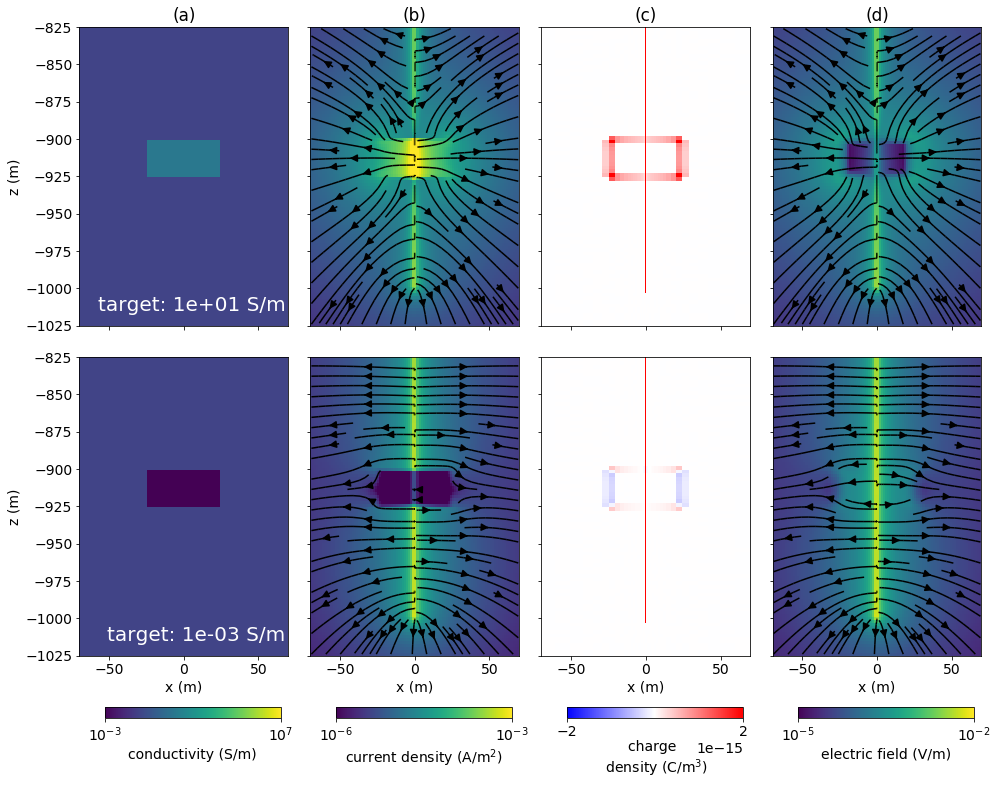

In [67]:
plot_physics("target")

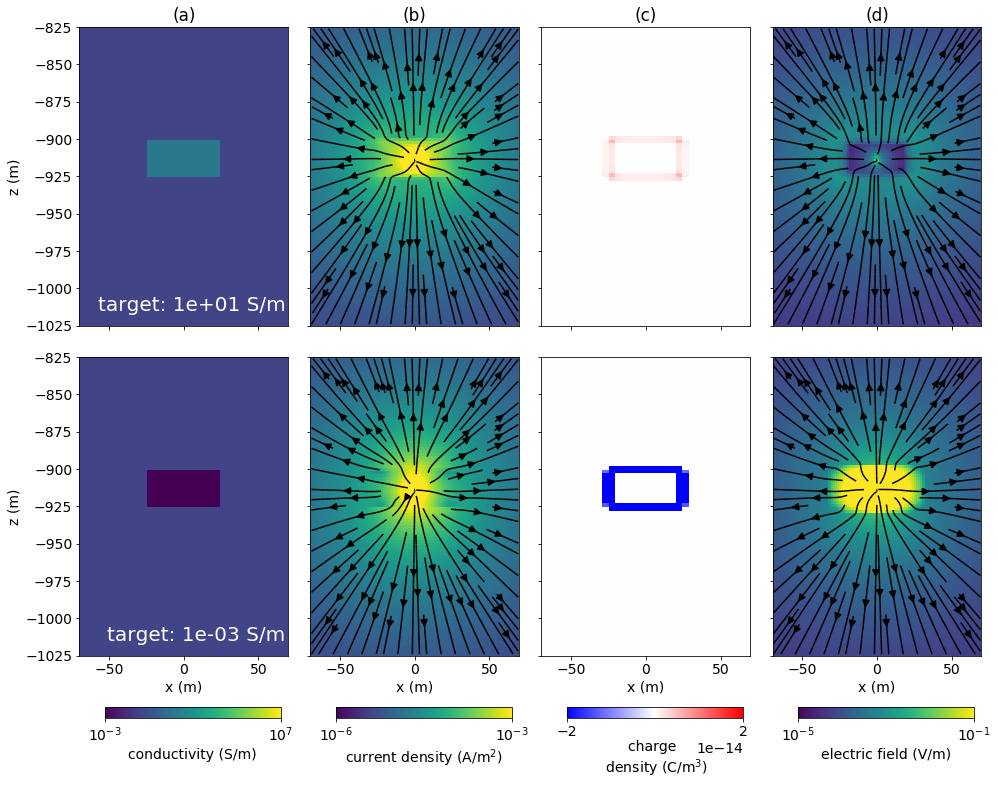

In [69]:
plot_physics("uncased")

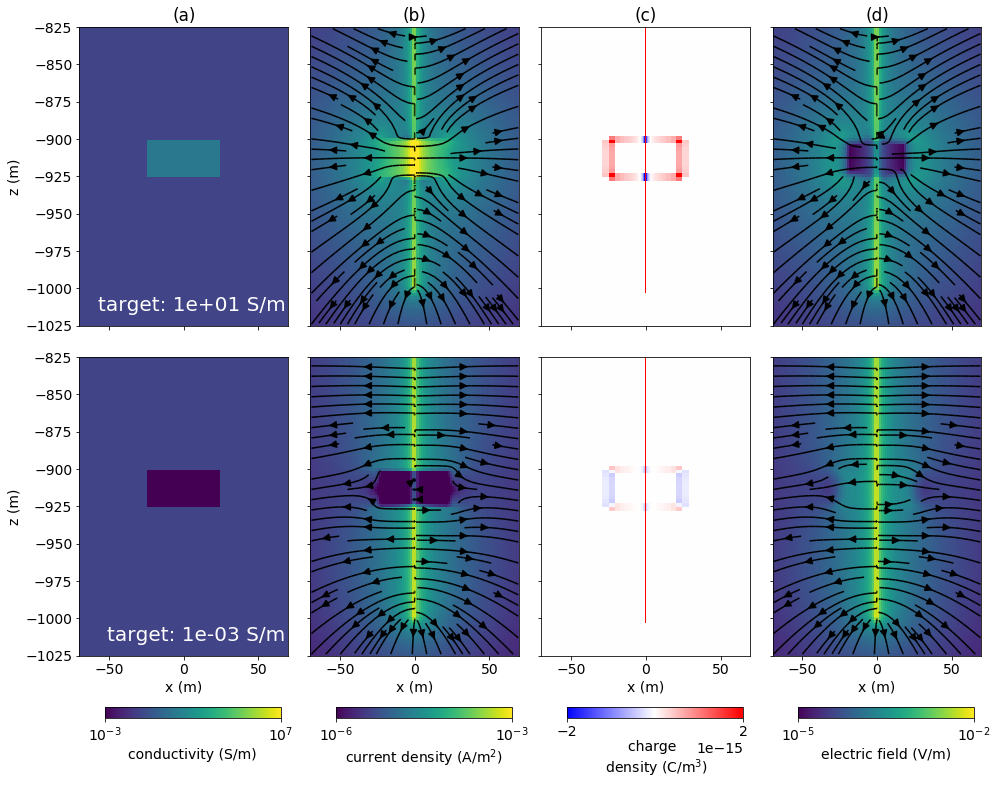

In [70]:
plot_physics("offset")

### Plot the electric fields on the surface

- Figures 16, 18

In [71]:
from matplotlib import lines as mlines

In [82]:
rcParams['font.size'] = 14

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


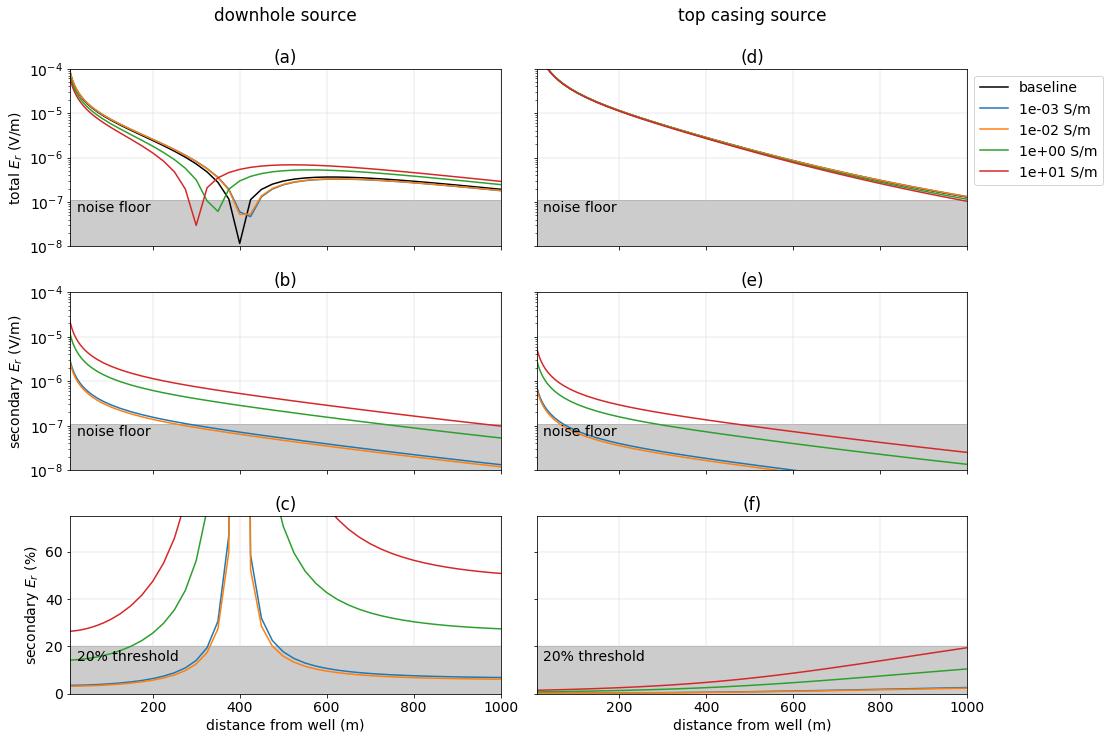

In [83]:
fig, axes = plt.subplots(3, 2, figsize = (14, 10.5)) #, dpi=350)

baseline_key = 'target_{:1.0e}'.format(sigma_back)

theta_ind = 4
xlim = [10., 1000.]
ylim = [1e-8, 1e-4]
ylim_percent = [0, 75]

noise_floor = 1e-7
min_percent = 20

unit = " S/m"

for j, src_ind in enumerate([1, 0]):
    ax = axes[:, j]

    plt_models = [m for m in model_names if m.startswith("target") and m != baseline_key]
#     plt_models.pop(baseline_key)
    plt_models = [baseline_key] + plt_models

    for i, key in enumerate(plt_models): 
        
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        baseline_src = simDict[baseline_key].survey.srcList[src_ind]
        label="{}".format(key.split("_")[-1] + unit) if key != baseline_key else "baseline"
        label=label

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=np.absolute(f[src,'e']),
            pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
            label=label, color_ind=i-1 if key != baseline_key else None,
            color = "k" if key == baseline_key else None
        )

        if key != baseline_key:
            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=(
                    np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
                ),
                pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
                label=label, color_ind=i-1
            )

            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=100*(
                    np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
                    (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
                ),
                pltType='plot', ax=ax[2], theta_ind=theta_ind,
                label=label, color_ind=i-1
            )

    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(ylim_percent)

    if j == 0: 
        ax[0].set_ylabel('total $E_r$ (V/m)')
        ax[1].set_ylabel('secondary $E_r$ (V/m)')
        ax[2].set_ylabel('secondary $E_r$ (%)')
    else:
        for a in ax: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))

    for i, a in enumerate(ax):
        letter = ascii_lowercase[(j*3) + i]
        a.set_title("({})".format(letter) if i > 0 else "{} source\n\n({})".format(src_names[src_ind], letter))
        a.set_xlim(xlim)
        if i < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            patch = patches.Rectangle(
                [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, noise_floor*0.6, "noise floor")

        else:
            patch = patches.Rectangle(
                [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, min_percent-6, "{}% threshold".format(min_percent),)

axes[0, 1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
            
fig.savefig('../figures/target_electric_fields', bbox_inches="tight", dpi=350)

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


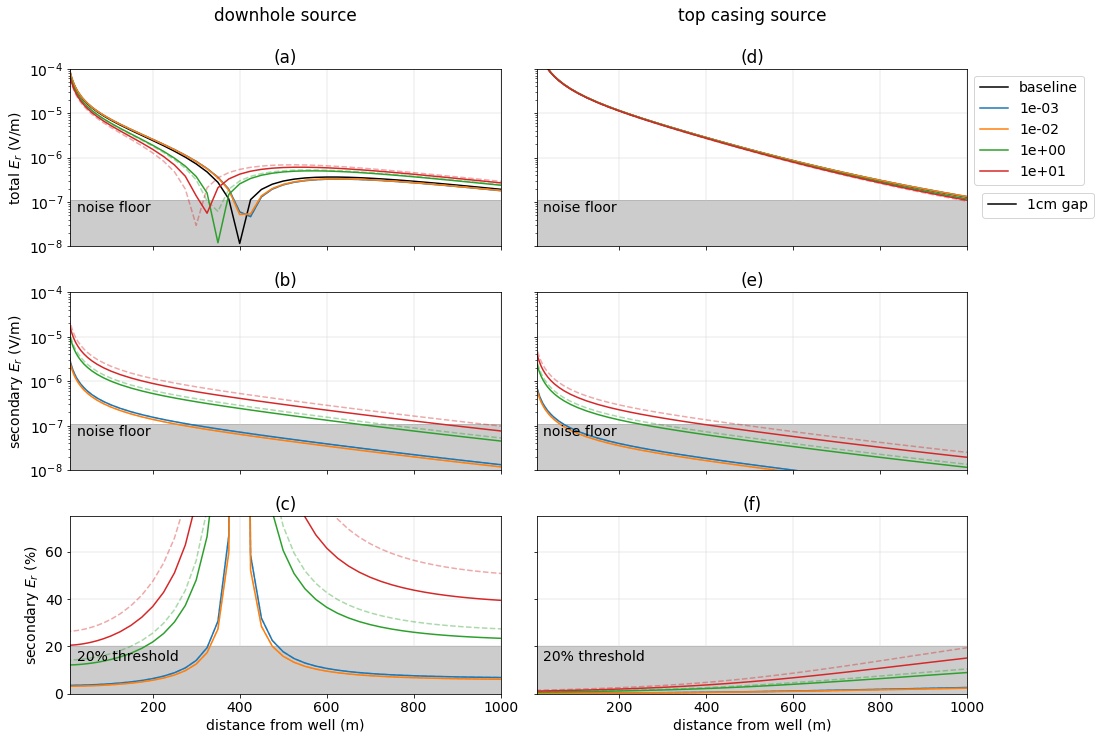

In [84]:
fig, axes = plt.subplots(3, 2, figsize = (14, 10.5)) #, dpi=350)
# ax = ax.flatten()

baseline_key = 'target_{:1.0e}'.format(sigma_back)

theta_ind = 4
xlim = [10., 1000.]
ylim = [1e-8, 1e-4]
ylim_percent = [0, 75]

noise_floor = 1e-7
min_percent = 20

unit = " S/m"


plt_sigma = [sigma_back] + [sig for sig in target_sigma if sig != sigma_back]

for j, src_ind in enumerate([1, 0]):
    ax = axes[:, j]

    for i, sig in enumerate(plt_sigma): 

        for key, ls, alpha in zip(["target_{:1.0e}".format(sig), "offset_{:1.0e}".format(sig), "offset2_{:1.0e}".format(sig)], ['--', '-', ':'], [0.4, 1, 1]):
            if key in model_names: 
                f = fieldsDict[key]
                src = simDict[key].survey.srcList[src_ind]
                baseline_src = simDict[baseline_key].survey.srcList[src_ind]
            #     label="{}".format(key.split("_")[-1] + unit)
                label="{:1.0e}".format(sig) if sig != sigma_back else "baseline"

                casingSim.view.plotLinesFx(
                    cylMeshGen.mesh,
                    field=np.absolute(f[src,'e']),
                    pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
                    label=label if ls == '-' or sig == sigma_back else None, 
                    color_ind=i-1 if sig != sigma_back else None,
                    color = "k" if sig == sigma_back else None,
                    linestyle=ls if sig != sigma_back else '-', 
                    alpha=alpha if sig != sigma_back else 1.,
                )

                if key != baseline_key:
                    casingSim.view.plotLinesFx(
                        cylMeshGen.mesh,
                        field=(
                            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
                        ),
                        pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
                        label=label, color_ind=i-1, linestyle=ls, alpha=alpha
                    )

                    casingSim.view.plotLinesFx(
                        cylMeshGen.mesh,
                        field=100*(
                            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
                            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
                        ),
                        pltType='plot', ax=ax[2], theta_ind=theta_ind,
                        label=label, color_ind=i-1, linestyle=ls, alpha=alpha
                    )
        

    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(ylim_percent)

    if j == 0: 
        ax[0].set_ylabel('total $E_r$ (V/m)')
        ax[1].set_ylabel('secondary $E_r$ (V/m)')
        ax[2].set_ylabel('secondary $E_r$ (%)')
    else:
        for a in ax: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))

    for i, a in enumerate(ax):
        letter = ascii_lowercase[(j*3) + i]
        a.set_title("({})".format(letter) if i > 0 else "{} source\n\n({})".format(src_names[src_ind], letter))
        a.set_xlim(xlim)
        if i < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            patch = patches.Rectangle(
                [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, noise_floor*0.6, "noise floor")

        else:
            patch = patches.Rectangle(
                [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, min_percent-6, "{}% threshold".format(min_percent),)
 
axes[0, 1].legend(bbox_to_anchor=(1, 1))

axes[1, 1].legend(
    handles=[
        mlines.Line2D([], [], color='k', linestyle='-', label='1cm gap'), 
#         mlines.Line2D([], [], color='k', linestyle=':', label='10 cm gap'),
#         mlines.Line2D([], [], color='k', linestyle='--', alpha=0.4, label='in contact')
    ], bbox_to_anchor=[1.31, 1.6]
)
plt.tight_layout()

fig.savefig('../figures/offset_electric_fields', bbox_inches="tight", dpi=350)

### Integrate charge in a volume

- produces table 1, table 2

In [96]:
def charge_in_volume(
    key, src_ind=0, radius=np.r_[0, 30], theta=np.r_[0., 2*np.pi], z=np.r_[-925., -900.], 
    primary_key="target_1e-01", secondary=False
):
    src = simDict[key].survey.srcList[src_ind]
    charge = fieldsDict[key][src, 'charge']
    
    if secondary is True:
        primary_src = simDict[primary_key].survey.srcList[src_ind]
        charge = charge - fieldsDict[primary_key][primary_src, 'charge']
    
    ind = [
        (mesh.gridCC[:, i] <= lim.max()) & (mesh.gridCC[:, i] >= lim.min()) 
        for i, lim in enumerate([radius, theta, z])
    ]
    ind = ind[0] & ind[1] & ind[2]
    
    return charge[ind].sum()

In [102]:
def latex_table_charge(key):
    for sig in [s for s in target_sigma]:
        target_0 = charge_in_volume(
            "{}_{:1.0e}".format(key if sig != sigma_back else "target", sig), src_ind=0, radius=np.r_[0, target_r.max() + csx2], z=target_z + csz*np.r_[-1, 1],
            secondary=True
        )
        target_1 = charge_in_volume(
            "{}_{:1.0e}".format(key if sig != sigma_back else "target", sig), src_ind=1, radius=np.r_[0, target_r.max() + csx2], z=target_z + csz*np.r_[-1, 1],
            secondary=True
        )
        print("{:1.0e} & {:1.2e} & {:1.2e} \\\\".format(sig, target_1, target_0))

In [103]:
latex_table_charge("target")

1e-03 & -4.24e-12 & -1.08e-12 \\
1e-02 & -3.82e-12 & -9.68e-13 \\
1e-01 & 0.00e+00 & 0.00e+00 \\
1e+00 & 1.75e-11 & 4.46e-12 \\
1e+01 & 3.26e-11 & 8.28e-12 \\


In [104]:
latex_table_charge("offset")

1e-03 & -4.24e-12 & -1.08e-12 \\
1e-02 & -3.80e-12 & -9.64e-13 \\
1e-01 & 0.00e+00 & 0.00e+00 \\
1e+00 & 1.49e-11 & 3.79e-12 \\
1e+01 & 2.51e-11 & 6.39e-12 \\
